This notebook walks through a complete machine learning workflow to classify celestial particles as either gamma rays (g) or hadronic showers (h) using data from the MAGIC (Major Atmospheric Gamma-ray Imaging Cherenkov) telescope.

The goal is to build a model that can accurately distinguish between these two types of particles based on the characteristics of the light showers they produce in the Earth's atmosphere.

1. Setup and Library Imports
First, let's set up our environment by installing the necessary library to fetch the data and importing all the Python libraries we'll need for data manipulation, visualization, and modeling.

In [1]:
# Install the ucirepo library to easily fetch the dataset
!pip install ucimlrepo -q

# Standard libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# A more advanced model
import xgboost as xgb

# Set plot style for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

2. Load the Dataset
We'll use the ucimlrepo library to directly fetch the MAGIC Gamma Telescope dataset from the UCI Machine Learning Repository. This is a convenient way to load the data without manual uploads.

In [2]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset from UCI
magic_gamma_telescope = fetch_ucirepo(id=159)

# Get features (X) and targets (y) as pandas DataFrames
X = magic_gamma_telescope.data.features
y = magic_gamma_telescope.data.targets

# For easier analysis, let's combine them into a single DataFrame
df = pd.concat([X, y], axis=1)

# Let's see the first few rows of our combined data
print("Dataset successfully loaded.")
df.head()

Dataset successfully loaded.


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


3. Exploratory Data Analysis (EDA) 🧐
Now, let's explore the data to understand its structure, distributions, and relationships. This is a critical step before building any models.

3.1. Basic Information and Missing Values
Let's check the data types, number of entries, and look for any missing values.

In [3]:
# Get a concise summary of the dataframe
df.info()

print("\n" + "="*50 + "\n")

# Check for any missing values in the dataset
print("Missing values in each column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


Missing values in each column:
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64


Observation: The dataset contains 19,020 entries and 11 columns. All features are numerical (float64), and the target (class) is an object (string). Importantly, there are no missing values, so we don't need to worry about imputation.

3.2. Target Variable Distribution
Let's see how many samples of each class (gamma vs. hadron) we have. An imbalanced dataset can bias our model.

/tmp/ipython-input-980149315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='viridis')


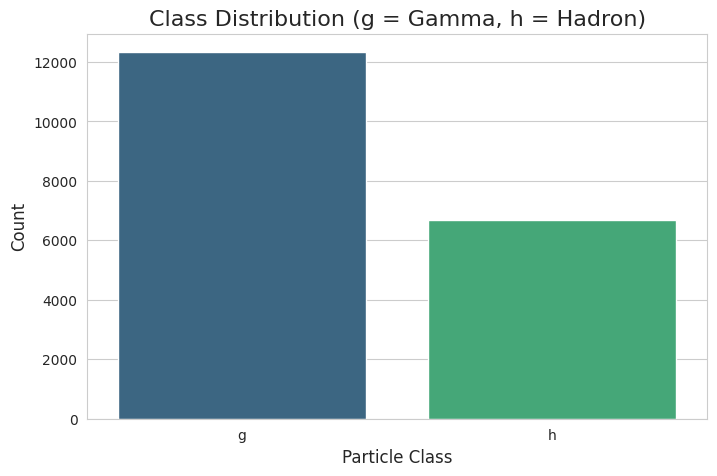

class
g    12332
h     6688
Name: count, dtype: int64


In [4]:
# Plot the distribution of the target variable 'class'
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Class Distribution (g = Gamma, h = Hadron)', fontsize=16)
plt.xlabel('Particle Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# Print the exact counts
print(df['class'].value_counts())

Observation: The classes are fairly well-balanced. We have about 12,332 gamma particle instances and 6,688 hadron instances. This is a good starting point, as we don't need to perform complex techniques like SMOTE for class imbalance.

3.3. Feature Distributions
Let's visualize the distributions of the numerical features to understand their scale and shape.



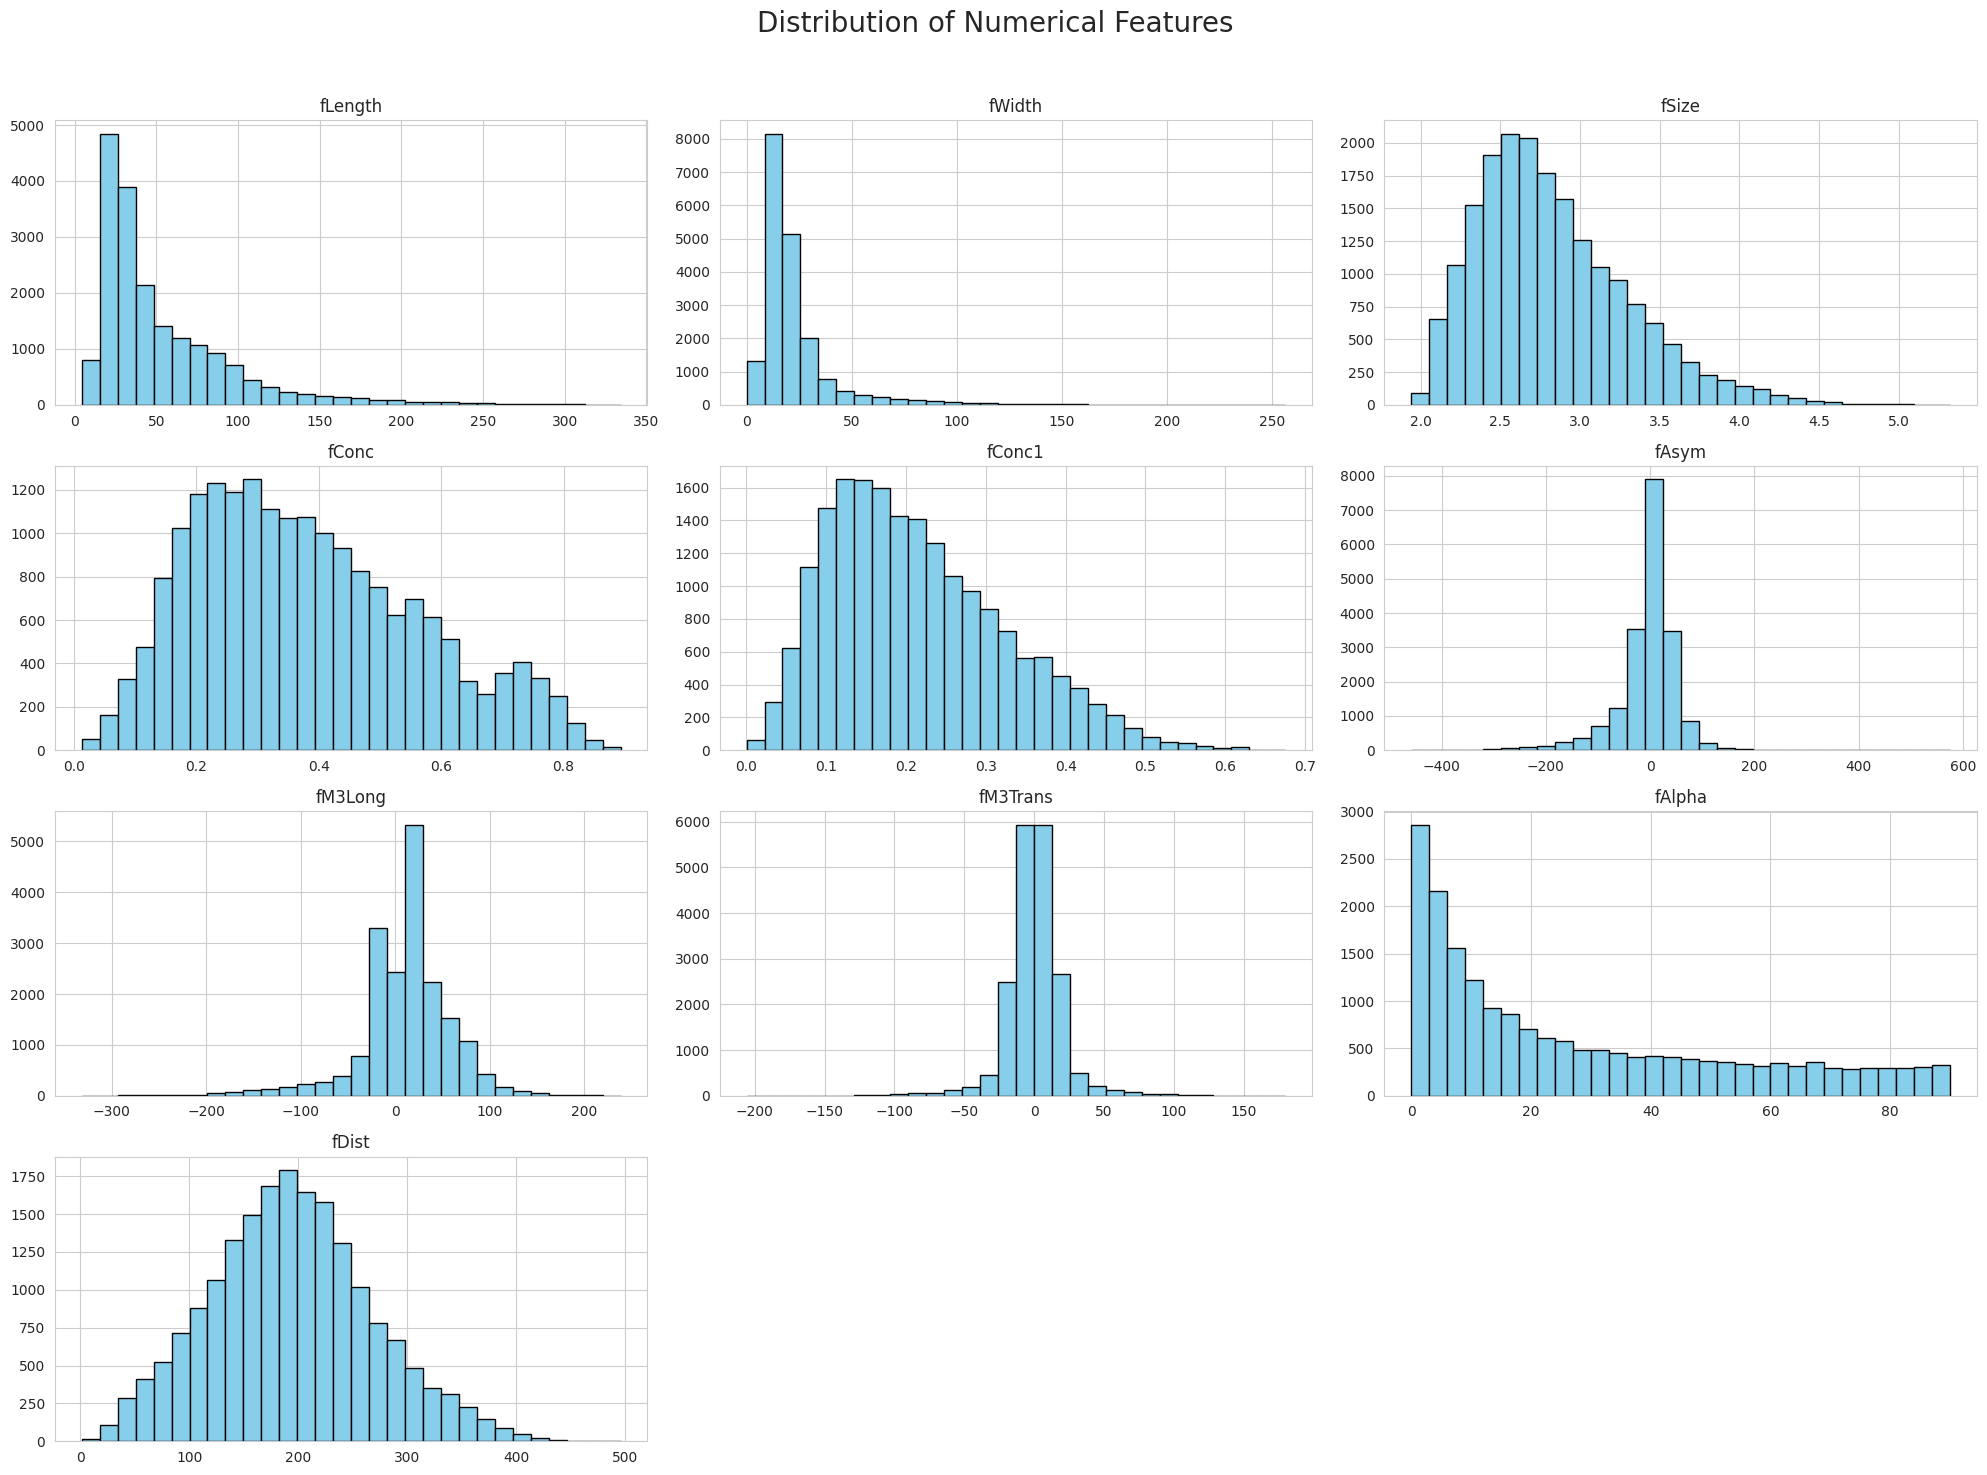

In [5]:
# Plot histograms for all numerical features
df.hist(bins=30, figsize=(20, 15), layout=(4, 3), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Observation: The features have widely different scales and distributions. For example, fLength ranges up to ~350, while fAlpha is mostly between 0 and 90. This confirms that feature scaling will be essential for models that are sensitive to the magnitude of features, like Logistic Regression.



3.4. Correlation Matrix
A correlation matrix helps us understand the linear relationships between features. High correlation between features (multicollinearity) can sometimes be problematic for certain models.



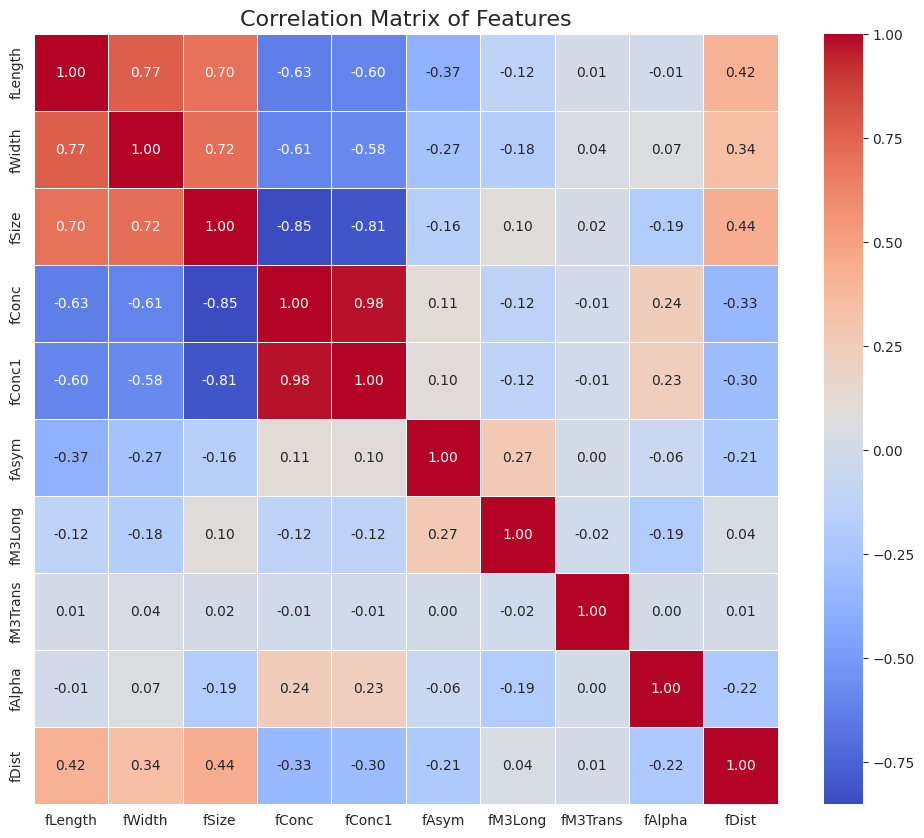

In [6]:
# Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()

Observation: We can see some strong correlations. For example, fSize and fConc have a strong positive correlation (0.78), and fLength and fWidth are also correlated. This is expected, as these features describe the geometry of the light shower.

4. Data Preprocessing
Before we can train our models, we need to prepare the data. This involves:

Encoding the target variable: Convert the categorical class labels ('g', 'h') into numerical format (e.g., 0 and 1).

Scaling the features: Standardize the features to have a mean of 0 and a standard deviation of 1. This helps models converge faster and perform better.

In [7]:
# 1. Encode the target variable 'class'
# We'll map 'g' (gamma) to 1 and 'h' (hadron) to 0
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

# Let's verify the mapping. The mapping is alphabetical: 'g' -> 1, 'h' -> 0
print("Class mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}' -> {i}")

# 2. Separate features (X) and target (y)
X = df.drop('class', axis=1)
y = df['class']

# 3. Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # for reproducibility
    stratify=y      # ensure same class proportion in train/test
)

# 4. Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Class mapping:
'g' -> 0
'h' -> 1

Training set shape: (15216, 10)
Testing set shape: (3804, 10)


5. Model Building and Training.
Now for the exciting part! We'll build and train three different classification models to see which one performs best on this task.

Logistic Regression: A great, simple baseline model.

Random Forest: A powerful and popular ensemble model.

XGBoost: A highly efficient and often state-of-the-art gradient boosting model.



In [8]:
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    print(f"{name} trained successfully.")

print("\nAll models have been trained!")

Training Logistic Regression...
Logistic Regression trained successfully.
Training Random Forest...
Random Forest trained successfully.
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:27:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained successfully.

All models have been trained!


Model Evaluation
With our models trained, we need to evaluate their performance on the unseen test data. We will look at:

Classification Report: Gives precision, recall, and F1-score for each class.

Accuracy: The overall percentage of correct predictions.

Confusion Matrix: A table showing what the model predicted versus the actual labels.

--- Evaluating Logistic Regression ---
Accuracy: 0.7992

Classification Report:
              precision    recall  f1-score   support

           g       0.81      0.90      0.85      2466
           h       0.77      0.61      0.68      1338

    accuracy                           0.80      3804
   macro avg       0.79      0.76      0.77      3804
weighted avg       0.80      0.80      0.79      3804



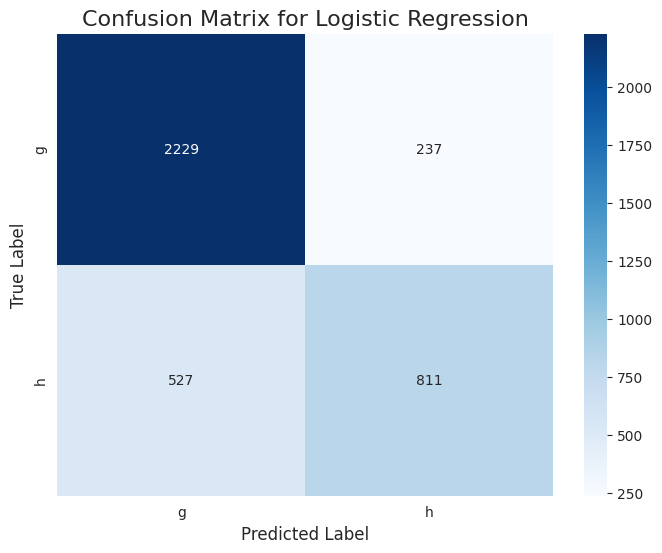



--- Evaluating Random Forest ---
Accuracy: 0.8867

Classification Report:
              precision    recall  f1-score   support

           g       0.89      0.94      0.92      2466
           h       0.88      0.78      0.83      1338

    accuracy                           0.89      3804
   macro avg       0.89      0.86      0.87      3804
weighted avg       0.89      0.89      0.88      3804



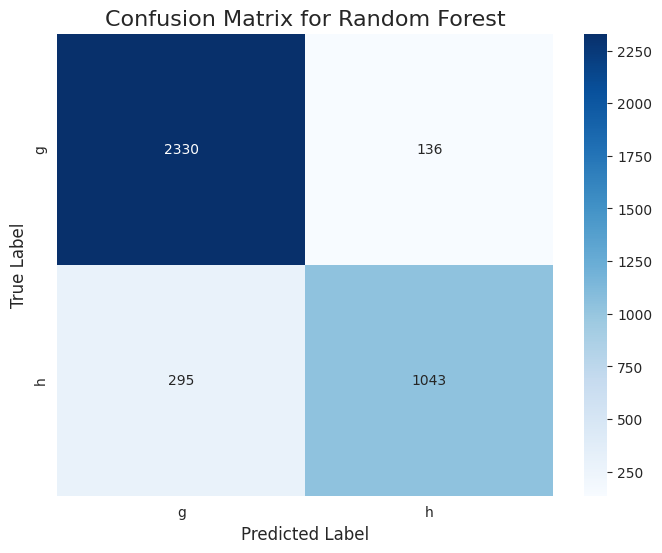



--- Evaluating XGBoost ---
Accuracy: 0.8817

Classification Report:
              precision    recall  f1-score   support

           g       0.89      0.94      0.91      2466
           h       0.87      0.78      0.82      1338

    accuracy                           0.88      3804
   macro avg       0.88      0.86      0.87      3804
weighted avg       0.88      0.88      0.88      3804



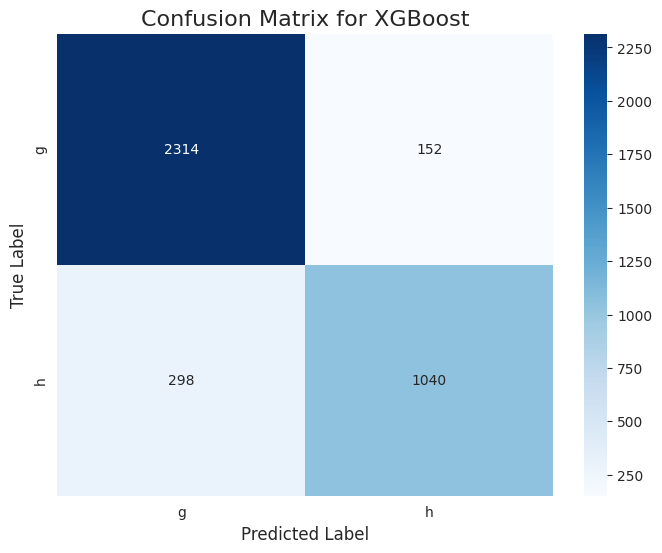

In [9]:
# Helper function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

# Evaluate each model
for name, model in models.items():
    print(f"--- Evaluating {name} ---")
    # Make predictions on the test data
    y_pred = model.predict(X_test_scaled)

    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    # Use target_names to show 'h' and 'g' instead of 0 and 1
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot the confusion matrix
    plot_confusion_matrix(y_test, y_pred, name)
    print("\n" + "="*50 + "\n")